<a href="https://colab.research.google.com/github/WittyTheMighty/Intro-to-RL/blob/main/Deep_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INF8953DE: Assignment 3 - Policy Gradient Methods
    
Due on : Nov 19, 10:00 pm 


# Policy Gradient Methods

In this assignment, you will code RL agents that will learn a parameterized policy to solve the [CartPole](https://gym.openai.com/envs/CartPole-v1/) task. Simply put, the CartPole task is to balance a pole on a cart. Towards that, you will code and analyze different policy gradient methods that can maximize the objective of balancing the pole on cart without falling for maximum time. 

## Environment Details

For this assignment, we will use the [CartPole-v1](https://gym.openai.com/envs/CartPole-v1/) environment provided in the [OpenAI-Gym](https://gym.openai.com/docs/). The following is a description of the task as given in the gym:

 **CartPole Task:** 
*A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.*
 
Detailed description and code can be found [here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py).




# Policy Gradient Skeleton Code

## Pseudocode
For this assignment you are asked to implement the policy gradient algorithms in the following pseudocode style. 

-------------------------------------------------------------------------------
**Input:** a differentiable policy network $\pi_\theta \in \mathcal{R}^d$ \\
**Algorithm parameters:** 


1.   $\alpha$: step size > 0
2.   n_iterations: number of gradient updates  > 0
3.   n_episodes: number of episodes per gradient update  > 0 

Initialize policy parameters 

loop for n_iterations: \\
  &emsp;&emsp;sample a dataset of episodes according to $\pi_\theta$ \\
  
  &emsp;&emsp;# compute policy gradient \\
  &emsp;&emsp;$\nabla_\theta J(\theta) = \sum_j \sum_t \psi_{jt} \nabla_\theta ln\pi_\theta (a_t^j|s_t^j)$ \\
  &emsp;&emsp; # where the first summation is over the episodes and the second summation is over the trajectory of the episode. \\
  
  &emsp;&emsp;# update policy parameters \\
  &emsp;&emsp;$\theta_i = \theta_i + \alpha \nabla_\theta J(\theta)$
  
------------------------------------------------------------------------------

Please note that this version of the algorithm is different from the one you will see in the textbook. Specifically, instead of computing the gradient for each episode, we collect a batch of episodes and then compute our gradient using this entire batch (or dataset).


## Installations and imports

In [ ]:
# Run this cell

# install dependencies
!pip install torch torchvision pyvirtualdisplay matplotlib seaborn pandas numpy pathlib gym
!sudo apt-get install xvfb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 784 kB in 2s (426 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package xvfb.
(Reading database ... 155222 files and directorie

In [ ]:
# Run this cell

# type hinting 
from typing import Sequence, Tuple, Dict, Any, Optional

import numpy as np

# torch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim

# env
import gym
from gym.wrappers import Monitor

# data manipulation, colab dispaly, and plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output

# misc util
import random, glob, base64, itertools
from pathlib import Path
from pprint import pprint

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


A util function to visualize the environment in colab:

In [ ]:
# Run this cell
def show_video(directory):
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
display = Display(visible=0, size=(1400, 900))
display.start(); 

## Building the Policy Network

The following piece of code is a util to make dense nets with PyTorch.

In [ ]:
# Run this cell
class Model(nn.Module):
    def __init__(self, features: Sequence[int]):
        """Fully-connected Network

        Args:
            features: a list of ints like: [input_dim, 16, 16, output_dim]
        """
        super(Model, self).__init__()
        
        layers = []
        for i in range(len(features) - 1):
            layers.append(
                nn.Linear(
                    in_features=features[i],
                    out_features=features[i + 1],
                    )
            )
            if i != len(features) - 2:
                layers.append(nn.ReLU())
        
        self.net = nn.Sequential(*layers)
        
    def forward(self, input):
        return self.net(input)

## Building the Base Agent Class

In [ ]:
# Run this cell
class BaseAgent(object):
    """ The base agent class function.
    """
    
    def __init__(self, config: Dict[str, Any]):
        """
        args:
            config: configuration dictionary
        """
        self.config = config

        # assert len(config['policy_layers']) > 0 # this won't allow linear models

        # environment
        self.env = gym.make(config['env_id'])
        self.gamma = config['gamma']

        # set seed
        np.random.seed(seed=config['seed'])
        self.env.seed(config['seed'])
        torch.manual_seed(config['seed'])

        # build policy model
        _policy_logits_model = Model(
            [self.env.observation_space.shape[0]] + 
            config['policy_layers'] + # note that these are only the intermediate layers
            [self.env.action_space.n],
        )
        # NOTE: by design, policy model should take *batches* of states as input.
        # self.policy_model spits out the probability of each action
        self.policy_model = nn.Sequential(
            _policy_logits_model, nn.Softmax(dim=1), 
        )
        self.policy_optimizer = torch.optim.Adam(
            self.policy_model.parameters(), 
            lr=config['policy_learning_rate'],
        )
        self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)

        if config['use_baseline']:
            self.value_model = Model(
              [self.env.observation_space.shape[0]] + 
              self.config['value_layers'] + [1],
            )
            self.value_optimizer = torch.optim.Adam(self.value_model.parameters(), lr=config['value_learning_rate'])
    
    def _make_returns(self, rewards: np.ndarray):
        """ Compute the cumulative discounted rewards at each time step

        args:
            rewards: an array of step rewards

        returns:
            returns: an array of discounted returns from that timestep onward
        """
        returns = np.zeros_like(rewards)
        returns[-1] = rewards[-1]
        for t in reversed(range(len(rewards) - 1)):
            returns[t] = rewards[t] + self.gamma * returns[t + 1]
        return returns
    
    # Method to implement
    def optimize_model(self, n_episodes: int) -> np.ndarray:
        """ Takes a gradient step on policy (and value) parameters using 
            `n_episodes` number of episodes. You'll need to implement
            this method for each part of this problem: namely, gather a 
            dataset of size `n_episodes`, approximate the gradient using 
            REINFORCE, and apply it to the model parameters. 

        args:
            n_episodes: number of trajectories in dataset

        returns:
            returns: the total discounted reward of each trajectory/episode.
        """
        
        raise NotImplementedError
    
    def train(self, n_episodes: int, n_iterations: int, plot: bool = True) -> Sequence[np.ndarray]:
        """ Train.
        args:
            n_episodes: number of episodes for each gradient step
            n_iterations: determine training duration
        """
        
        rewards = []
        for it in range(n_iterations):
            rewards.append(self.optimize_model(n_episodes))
            print(f'Iteration {it + 1}/{n_iterations}: rewards {round(rewards[-1].mean(), 2)} +/- {round(rewards[-1].std(), 2)}')

        if plot:
            self.plot_rewards(rewards)

        return(rewards)
        
    @staticmethod
    def plot_rewards(rewards: Sequence[np.ndarray], ax: Optional[Any] = None):
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), columns=['Epoch', 'Reward'])
        if ax is None:
            sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        else:
            sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd', ax=ax);
        
    def evaluate(self):
        """ Evaluate and visualize a single episode.
        """
        
        observation = self.monitor_env.reset()
        observation = torch.tensor(observation, dtype=torch.float)[None, :]
        reward_episode = 0
        done = False
            
        while not done:
            probs = self.policy_model.forward(observation)
            action = torch.multinomial(probs, 1)[0] # draw samples from dist
            observation, reward, done, info = self.monitor_env.step(int(action))
            observation = torch.tensor(observation, dtype=torch.float)[None, :]
            reward_episode += reward
        
        self.monitor_env.close()
        show_video("./gym-results")
        print(f'Reward: {reward_episode}')
        

#Qn 1. REINFORCE ALGORITHM [65 Marks]

## Qn 1.1 REINFORCE with episodal returns [25 Marks]


### Qn1.1.a: Implement a `REINFORCEv1` agent [20 Marks]

Implement a REINFORCE agent below with the following policy gradient computation.

&emsp;&emsp; $\nabla_\theta J(\theta) = \sum_j \sum_t G_0^j \nabla_\theta ln\pi_\theta (a_t^j|s_t^j)$ \\
where $G_0^j=\sum_{k = 0}^{\infty} \gamma^{k} R_{k+1}^j$ is the discounted return for the start state, $s_0^j$ for the episode $j$. . \\

Note that this is different from the REINFORCE algorithm we have seen in the class since we are using only the episodal return in the policy gradient computation for all state updates instead of using the corresponding return from individual states. We will implement the in-class version of REINFORCE in the next part.

You will be graded primarily on the output of the agent.train() and agent.evaluate() functions for this question.


In [ ]:
# Insert your code and run this cell
from torch.autograd import Variable
from torch.distributions import Categorical
import copy
class REINFORCEv1Agent(BaseAgent):
    """ REINFORCE agent with total trajectory reward.
    """

    def optimize_model(self, n_episodes: int):
        """ YOU NEED TO IMPLEMENT THIS METHOD

            This method is called at each training iteration and is responsible for
            (i) gathering a dataset of episodes
            (ii) computing the expectation of the policy gradient.
                 Note that you will only be computing the loss value

            HINTS:

                    * Note that policy network model (self.policy_model) outputs the
                    probability of taking each discrete action. Hence, you need
                to sample from this distribution. Take a look at `self.evaluate()`
                method in the `BaseAgent` class.

                * Keep in mind that policy network takes batches of states as
                input, as opposed to a single state vector. This is by design,
                and good/common practice, however, you need to keep an eye on
                the input/output dimensions.

        """

        # INSERT YOUR CODE HERE !

        rewards_batch = []
        log_probs_batch = []
        total_rewards =[]
        for iter in range(n_episodes):
            observation = self.env.reset()
            return_episode = 0
            done = False
            rewards = []
            log_probs = []

            while not done:
                observation = torch.tensor(observation, dtype=torch.float)[None, :]
                probs = self.policy_model.forward(observation)
                m = Categorical(probs)
                # action = m.sample()
                action = torch.multinomial(probs, 1)[0]  # draw samples from dist
                observation, reward, done, info = self.env.step(int(action))
                # Append vector
                log_probs.append(-m.log_prob(action))
                return_episode += reward


                rewards.append(reward)

            # Log probs batch
            total_rewards.append(return_episode)
            log_probs_batch.append(log_probs)
            rewards_batch.append(rewards)
        G_batch=[]
        for rewards in rewards_batch:
            g0 = 0
            for i,reward in enumerate((rewards)):
                g0 += self.gamma**(i) *reward
            G_batch.append(g0)
        loss = 0

        for probs, G in zip(log_probs_batch, G_batch):
            loss += sum([prob*G for prob in probs])

        # ======================================================================
        self.policy_optimizer.zero_grad()
        loss.backward()
        self.policy_optimizer.step()
        return np.array(total_rewards)


Iteration 1/100: rewards 18.28 +/- 8.44
Iteration 2/100: rewards 16.74 +/- 4.84
Iteration 3/100: rewards 21.42 +/- 11.21
Iteration 4/100: rewards 20.02 +/- 11.18
Iteration 5/100: rewards 20.84 +/- 13.11
Iteration 6/100: rewards 22.5 +/- 10.26
Iteration 7/100: rewards 22.4 +/- 11.46
Iteration 8/100: rewards 24.98 +/- 12.99
Iteration 9/100: rewards 21.3 +/- 8.47
Iteration 10/100: rewards 25.46 +/- 15.24
Iteration 11/100: rewards 25.3 +/- 10.97
Iteration 12/100: rewards 26.72 +/- 16.78
Iteration 13/100: rewards 28.94 +/- 15.54
Iteration 14/100: rewards 24.36 +/- 10.87
Iteration 15/100: rewards 28.08 +/- 16.78
Iteration 16/100: rewards 30.5 +/- 16.24
Iteration 17/100: rewards 29.8 +/- 17.04
Iteration 18/100: rewards 35.96 +/- 20.14
Iteration 19/100: rewards 35.06 +/- 19.67
Iteration 20/100: rewards 36.44 +/- 20.72
Iteration 21/100: rewards 34.64 +/- 19.68
Iteration 22/100: rewards 34.02 +/- 16.76
Iteration 23/100: rewards 38.34 +/- 20.77
Iteration 24/100: rewards 41.92 +/- 23.4
Iteration 2

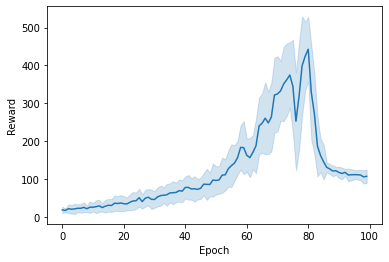

In [ ]:
# You will be graded on this output this cell, so kindly run it

# This is an example configuration that is tuned for the above question. 
# keep the same config
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 1.0,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-2,
    'use_baseline': False,
}
agent = REINFORCEv1Agent(config)
REINFORCEv1_rewards = agent.train(n_episodes=50, n_iterations=100)

In [ ]:
# You will be graded on this output this cell, so kindly run it
agent.evaluate() 

Reward: 108.0


### Qn:1.1.b:Why can we allow ourselves to use $\gamma = 1.0$ here? [3 Marks]


Here, we allow ourself to use $\gamma$=1 because it allow us to consider all futures steps equally. This might be important in a reinforcement learning problem like the cartpole problem because a bad sliding action might lead to a failure in the future. For example if the agent is mostly sliding left the carpole will get out of the frame and get a lower reward.

Usually, we use a discount factor to prevent unrelevant reward loop. In this problem. Here, we want to repeat action that keep the pole straigth. 



### Qn 1.1.c: If you have implemented everything correctly, you will notice that training iterations tend to take a bit longer towards the end compared to early stages of the training, why? [2 Marks]


This is because the reinforcement algorithm learn an optimal policy over time. Therefore, it takes longer for the agent to finish an episodes. The longer time leads to bigger array which takes more computations.  The simulation stop at 500 rewards.

## Qn 1.2 REINFORCE with returns [15 Marks]




###Qn 1.2.a Implement `REINFORCEv2` agent as described below. [10 Marks]

Implement a REINFORCE agent below with the following policy gradient computation.

&emsp;&emsp; $\nabla_\theta J(\theta) = \sum_j \sum_t G_t^j \nabla_\theta ln\pi_\theta (a_t^j|s_t^j)$ \\
where $G_t^j=\sum_{k=0}^{\infty} \gamma^{k} R_{t+k+1}^j$ is the discounted return computed starting from the current state, $s_t^j$ for the episode $j$. \\

Let's call this agent REINFORCEv2.

Note that you will be graded primarily on the output of the agent.train() and agent.evaluate() functions for this question.

In [ ]:
class REINFORCEv2Agent(BaseAgent):

        """ Not Vanilla REINFORCE Agent:
            *Not* vanilla, in the sense that we are now going to weight the action
            logprobs, proportionate to the onward return as opposed to the total
            episodic return.
        """

        def optimize_model(self, n_episodes: int):
            """ YOU NEED TO IMPLEMENT THIS METHOD

                This method is called at each training iteration and is responsible for
                (i) gathering a dataset of episodes
                (ii) computing the expectation of the policy gradient.
                     Note that you will only be computing the loss value

                HINTS:
                    Hints from the previous section hold here except/plus that:

                    * You probably DO need to call the `BaseAgent._make_returns`
                    method in this part.

                    * You basically need to copy a lot of stuff you've done in the
                    previous part, but have to scale the logprobs with different
                    values.
            """
            # ======================================================================

            rewards_batch = []
            log_probs_batch = []
            total_rewards = []
            for iter in range(n_episodes):
                observation = self.env.reset()
                return_episode = 0
                done = False
                rewards = []
                actions = []
                log_probs = []
                while not done:
                    observation = torch.tensor(observation, dtype=torch.float)[None, :]
                    probs = self.policy_model.forward(observation)
                    m = Categorical(probs)
                    action = m.sample()
                    # action = torch.multinomial(probs, 1)[0]  # draw samples from dist
                    observation, reward, done, info = self.env.step(int(action))
                    # Append vector
                    log_probs.append(-m.log_prob(action))
                    rewards.append(reward)
                    return_episode += reward

                # Log probs batch
                log_probs_batch.append(log_probs)
                rewards_batch.append(np.array(rewards))

                total_rewards.append(return_episode)

            returns = [self._make_returns(rewards_episode) for rewards_episode in rewards_batch]

            loss = 0
            for episodes_return, probs in zip(returns, log_probs_batch):
                loss += sum([float(g)*prob for g,prob in zip(episodes_return, probs)])


            # ======================================================================

            self.policy_optimizer.zero_grad()
            loss.backward()
            self.policy_optimizer.step()
            return np.array(total_rewards)

Iteration 1/100: rewards 20.78 +/- 9.36
Iteration 2/100: rewards 18.9 +/- 7.82
Iteration 3/100: rewards 18.8 +/- 9.81
Iteration 4/100: rewards 20.0 +/- 8.08
Iteration 5/100: rewards 21.9 +/- 12.58
Iteration 6/100: rewards 22.04 +/- 10.47
Iteration 7/100: rewards 29.26 +/- 15.51
Iteration 8/100: rewards 26.44 +/- 16.12
Iteration 9/100: rewards 26.84 +/- 14.93
Iteration 10/100: rewards 30.6 +/- 19.68
Iteration 11/100: rewards 29.76 +/- 21.25
Iteration 12/100: rewards 28.94 +/- 15.54
Iteration 13/100: rewards 30.44 +/- 13.92
Iteration 14/100: rewards 28.1 +/- 14.19
Iteration 15/100: rewards 32.14 +/- 16.25
Iteration 16/100: rewards 35.66 +/- 21.99
Iteration 17/100: rewards 34.12 +/- 15.71
Iteration 18/100: rewards 38.76 +/- 21.99
Iteration 19/100: rewards 36.54 +/- 18.44
Iteration 20/100: rewards 40.8 +/- 20.72
Iteration 21/100: rewards 43.98 +/- 21.13
Iteration 22/100: rewards 43.42 +/- 18.42
Iteration 23/100: rewards 53.48 +/- 26.31
Iteration 24/100: rewards 50.72 +/- 23.97
Iteration 25

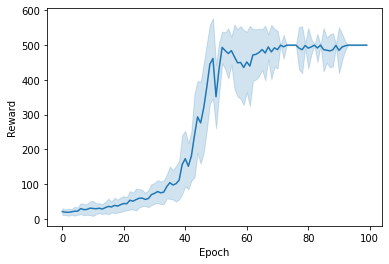

In [ ]:
# You will be graded on this output this cell, so kindly run it
# keep the same config
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 1.0,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-2,
    'use_baseline': False,
}
agent = REINFORCEv2Agent(config)
REINFORCEv2_rewards = agent.train(n_episodes=50, n_iterations=100)

In [ ]:
# You will be graded on this output this cell, so kindly run it
agent.evaluate()

Reward: 500.0


### Qn 1.2.b: Plot and compare the performance of the `REINFORCEv1` and `REINFORCEv2` agents for $\gamma=1$. Report your observations and provide explanations for the same. [5 Marks]


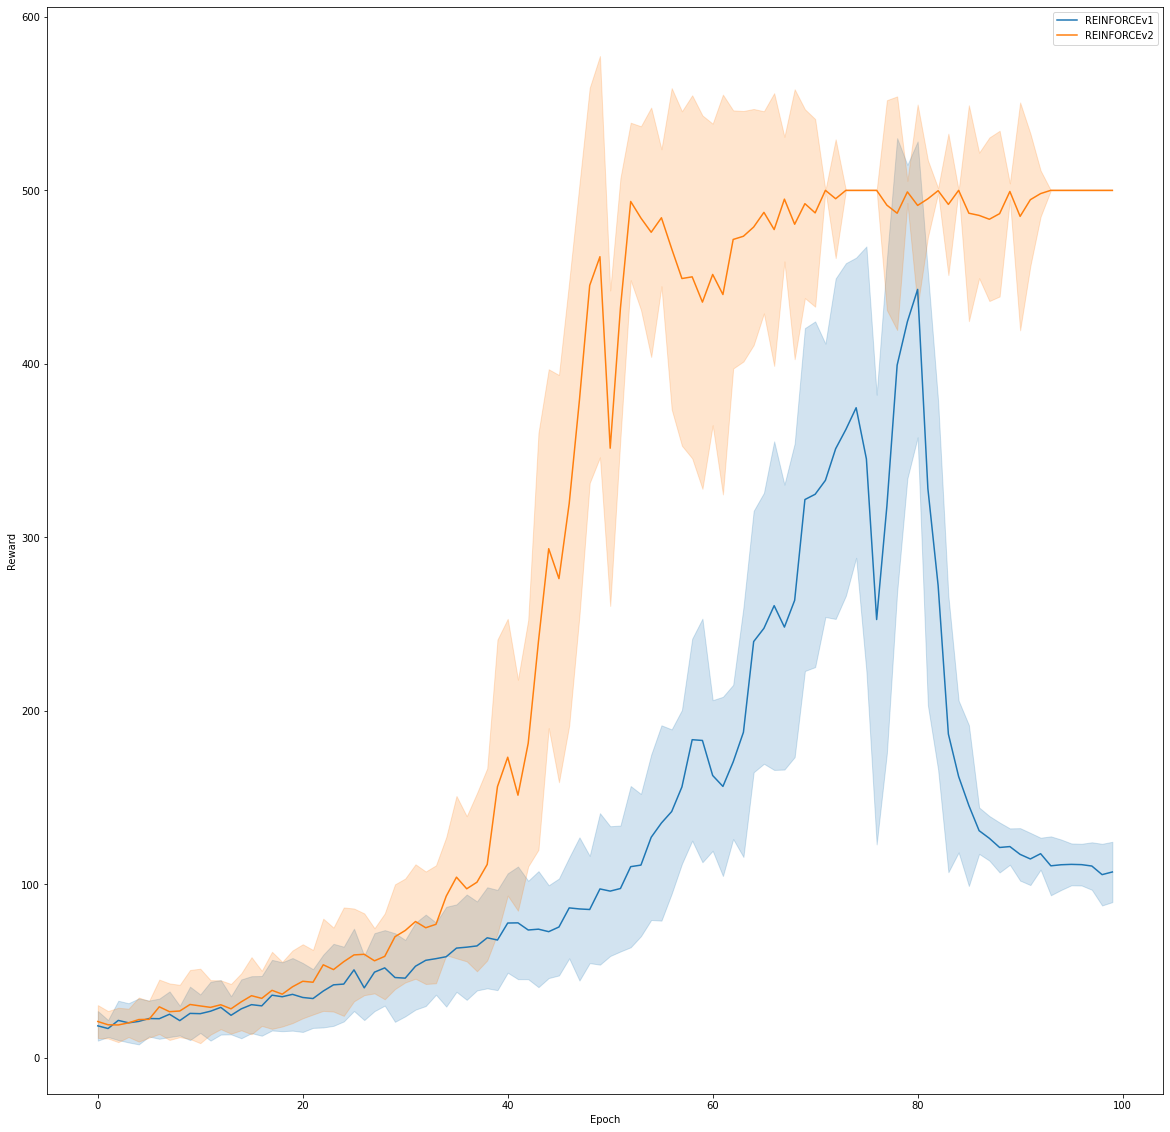

In [ ]:
# You will be graded on this output this cell, so kindly run it
fig, ax = plt.subplots()
BaseAgent.plot_rewards(REINFORCEv1_rewards, ax)
BaseAgent.plot_rewards(REINFORCEv2_rewards, ax)
plt.rcParams['figure.figsize'] = [20, 20]
plt.legend(labels=['REINFORCEv1', 'REINFORCEv2'])

The reinforceV2 is converging faster to high values then the reinforcev1 algorithm. With the current seed, the reinforcement agent 1 is converging to reward of 100. (However, on my personnal device the reinforcev1 algorithm is converging to value near 500 like the the reinforcev2 algorithm)

The reinforcev2 algorithm is converging faster because of the more accurate Gt values at each step. This might help to push the gradient in the right direction because bad action might lead to smaller return where as in the reinforcev1 algorithm the G values are not ajusted overtime in one episode. We only take the return at step 0. We don't know at what step we have a decrease in performance. This might explain why reinforcev1 algorithm is taking a longer time to converge. This different seems to make a difference in the variance according to the result the blue curve have a much high variance especially around 70-80 epochs.

##Qn 1.3 REINFORCE WITH baseline 25 Marks]

### Qn 1.3.a Implement 'REINFORCEv2+B' agent as described below [15 Marks]

Implement a REINFORCE agent below with the following policy gradient computation.

&emsp;&emsp; $\nabla_\theta J(\theta) = \sum_j \sum_t (G_t^j - B(s_t^j)) \nabla_\theta ln\pi_\theta (a_t^j|s_t^j)$ \\
where $G_t^j=\sum_{k=0}^{\infty} \gamma^{k} r_{t+k+1}^j$ is the discounted return computed starting from the current state, $s_t^j$ for the episode $j$. \\

Herein implement the baseline to be an estimator of the state-value function of the state at $t$, $B(s_t)=V(s_t)$. Towards that implement a value network with parameters, $w$ to estimate the value of a state,i.e $B(s_t, w) = V(s_t)$. 

Let's call this agent REINFORCEv2+B.

Note that you will be graded primarily on the output of the agent.train() and agent.evaluate() functions for this question.

In [ ]:
# Insert your code and run this cell
class REINFORCEv2PlusBaselineAgent(BaseAgent):
    """ Baseline Agent: 
        Here we try to reduce the variance by introducing a baseline, which is 
        the value function in this case.
    """
    
    def optimize_model(self, n_episodes: int):
        """ YOU NEED TO IMPLEMENT THIS METHOD 

            This method is called at each training iteration and is responsible for 
            (i) gathering a dataset of episodes
            (ii) computing the expectation of the policy gradient.
                 Note that you will only be computing the loss value

            In addition here, you will have to compute the loss of the value function and 
            call auto-diff on this loss to updae the parameters of the value network.

            Here you have access to and need to make use of `self.value_model`
            and `self.value_optimizer`, and have to form a loss for updating the
            value function. 

            HINT:
                * You need to use torch's `.detach()` to prevent re-flowing 
                the gradients.
        """
        # ======================================================================
        rewards_batch = []
        log_probs_batch = []
        total_rewards = []
        values_batch = []
        for iter in range(n_episodes):
            observation = self.env.reset()
            return_episode = 0
            done = False
            rewards = []
            log_probs = []
            values = []
            while not done:
                observation = torch.tensor(observation, dtype=torch.float)[None, :]
                probs = self.policy_model.forward(observation)
                m = Categorical(probs)
                action = torch.multinomial(probs, 1)[0]

                value = self.value_model.forward(observation)

                # action = torch.multinomial(probs, 1)[0]  # draw samples from dist
                observation, reward, done, info = self.env.step(int(action))


                # Append vector
                log_probs.append(-m.log_prob(action))
                rewards.append(reward)
                return_episode += reward
                values.append(value.type(torch.float64))
            # Log probs batch

            log_probs_batch.append(log_probs)
            rewards_batch.append(np.array(rewards))
            total_rewards.append(return_episode)
            values_batch.append(values)
        returns = [self._make_returns(rewards_episode) for rewards_episode in rewards_batch]
        policy_loss = 0
        value_loss = 0
        criterion = nn.MSELoss()

        for episodes_return, prob, values in zip(returns, log_probs_batch, values_batch):

            advantage = [ep_return-value for ep_return,value in zip(episodes_return,values)]
            policy_loss += sum([float(advantage[i])*p for i,p in enumerate(prob)])
            x =Variable(torch.tensor(values), requires_grad=True)
            y = Variable(torch.tensor(episodes_return))
            value_loss += torch.sqrt(criterion(x,y))


        # ======================================================================
        #Policy optimizer
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        #Baseline backpropagation
        # additionally we update the value network parameters
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        return np.array(total_rewards)

Iteration 1/100: rewards 18.7 +/- 9.48
Iteration 2/100: rewards 20.44 +/- 8.46
Iteration 3/100: rewards 19.84 +/- 10.24
Iteration 4/100: rewards 23.28 +/- 14.17
Iteration 5/100: rewards 23.44 +/- 11.48
Iteration 6/100: rewards 25.28 +/- 11.94
Iteration 7/100: rewards 27.12 +/- 12.61
Iteration 8/100: rewards 23.3 +/- 10.88
Iteration 9/100: rewards 26.76 +/- 14.67
Iteration 10/100: rewards 35.7 +/- 20.98
Iteration 11/100: rewards 27.88 +/- 15.96
Iteration 12/100: rewards 29.02 +/- 14.78
Iteration 13/100: rewards 32.58 +/- 17.74
Iteration 14/100: rewards 30.24 +/- 15.51
Iteration 15/100: rewards 36.4 +/- 22.05
Iteration 16/100: rewards 40.5 +/- 20.39
Iteration 17/100: rewards 40.48 +/- 17.04
Iteration 18/100: rewards 44.96 +/- 22.86
Iteration 19/100: rewards 47.96 +/- 23.84
Iteration 20/100: rewards 43.44 +/- 19.4
Iteration 21/100: rewards 47.54 +/- 23.2
Iteration 22/100: rewards 52.06 +/- 27.0
Iteration 23/100: rewards 50.2 +/- 33.15
Iteration 24/100: rewards 56.26 +/- 25.41
Iteration 25

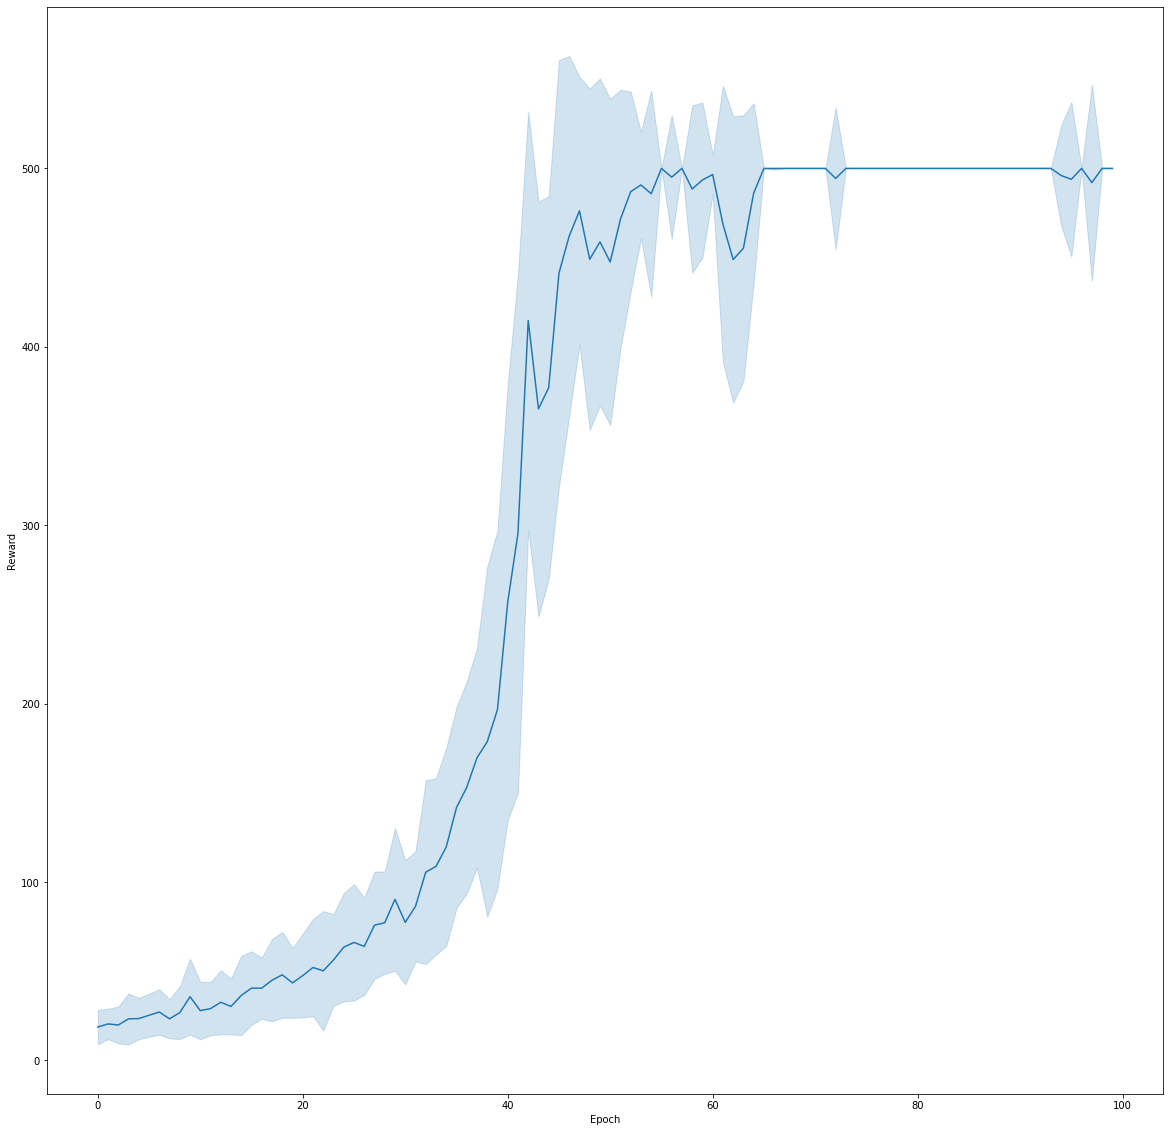

In [ ]:
# You will be graded on this output this cell, so kindly run it.
# keep the config
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 1.0,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-2,
    'use_baseline': True,
    'value_layers': [16, 8, 8],
    'value_learning_rate': 5e-3,
}
agent = REINFORCEv2PlusBaselineAgent(config)
REINFORCEv2PlusBaselineAgent_rewards = agent.train(n_episodes=50, n_iterations=100)

In [ ]:
# You will be graded on this output this cell, so kindly run this cell.
agent.evaluate()

Reward: 500.0


### Qn 1.3.b : Does introducing baselines have a meaning beyond variance reduction? [5 Marks ]


Variance reduction can lead to a faster convergence state [1]. However, it has be shown that baseline can have a broader impact then only reducing the variance. Recent work showed that baseline can lead to a qualitatively different learning curves even when the variance of the gradient is the same [2]. Depending on the baseline strength, it is possible to have a comittal behavior or a non-commital behavior. The type of baseline can impact the convergence of natural policy gradient. [2] 

If we analyze the formula, $\nabla_\theta J(\theta) = \sum_j \sum_t (G_t^j - B(s_t^j)) \nabla_\theta ln\pi_\theta (a_t^j|s_t^j)$, we see that the difference $(G_t^j - B(s_t^j))$ can vary depending on the baseline value. If this expression is negative, the parameter update will decreases the probability $\pi_θ$ of the sample action [2]. Then learn agent will avoid to repeat action that gives bad return. Moreover, the baseline values can impact the behavior of the learning curve even if the variance between two experiments is the same. Finally, the baseline can impact the convergence value. Indeed, if the vaseline induce a too strong commital behavior the learning can converge to a suboptimal state [2].

In conclusion, the choice of baseline can have an impact on how the agent will learn.

### Qn 1.3.c Plot and compare `REINFORCEv2+B` for  $\gamma \in \{0.95, 0.975, 0.99, 0.995, 1\}$. [ 5 Marks]
Report your observations and explain the same.

Training for gamma: 0.95
Iteration 1/100: rewards 18.7 +/- 9.48
Iteration 2/100: rewards 20.44 +/- 8.46
Iteration 3/100: rewards 19.84 +/- 9.73
Iteration 4/100: rewards 22.78 +/- 13.13
Iteration 5/100: rewards 23.94 +/- 10.42
Iteration 6/100: rewards 26.74 +/- 16.5
Iteration 7/100: rewards 21.08 +/- 9.97
Iteration 8/100: rewards 23.28 +/- 12.18
Iteration 9/100: rewards 30.0 +/- 14.57
Iteration 10/100: rewards 28.68 +/- 13.74
Iteration 11/100: rewards 29.52 +/- 17.33
Iteration 12/100: rewards 32.06 +/- 16.8
Iteration 13/100: rewards 32.76 +/- 18.23
Iteration 14/100: rewards 30.0 +/- 16.56
Iteration 15/100: rewards 32.22 +/- 17.7
Iteration 16/100: rewards 40.06 +/- 22.74
Iteration 17/100: rewards 36.94 +/- 19.27
Iteration 18/100: rewards 47.06 +/- 33.93
Iteration 19/100: rewards 45.84 +/- 23.03
Iteration 20/100: rewards 47.02 +/- 24.41
Iteration 21/100: rewards 43.88 +/- 21.47
Iteration 22/100: rewards 54.6 +/- 25.47
Iteration 23/100: rewards 56.2 +/- 26.89
Iteration 24/100: rewards 60.1

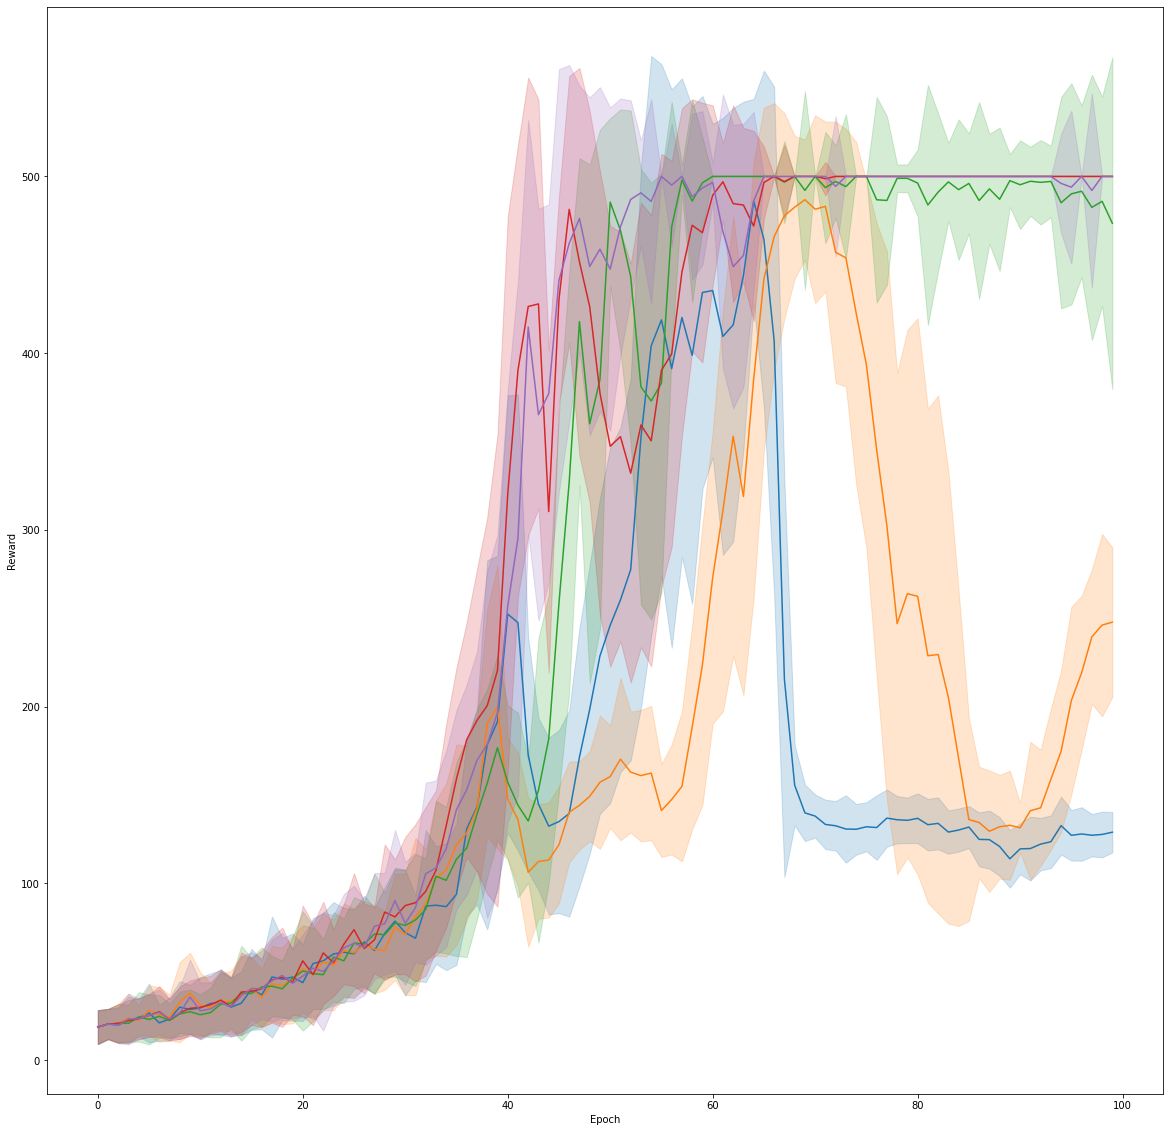

In [ ]:
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 1.0,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-2,
    'use_baseline': True,
    'value_layers': [16, 8, 8],
    'value_learning_rate': 5e-3,
}
gammas = [0.95,0.975,0.99,0.995,1]

training_rewards_array = []
for gamma in gammas:
    print("Training for gamma:",gamma)
    config["gamma"] = gamma
    agent = REINFORCEv2PlusBaselineAgent(config)
    training_rewards = agent.train(n_episodes=50, n_iterations=100)
    training_rewards_array.append(copy.deepcopy(training_rewards))


###See the figure bellow more clear.

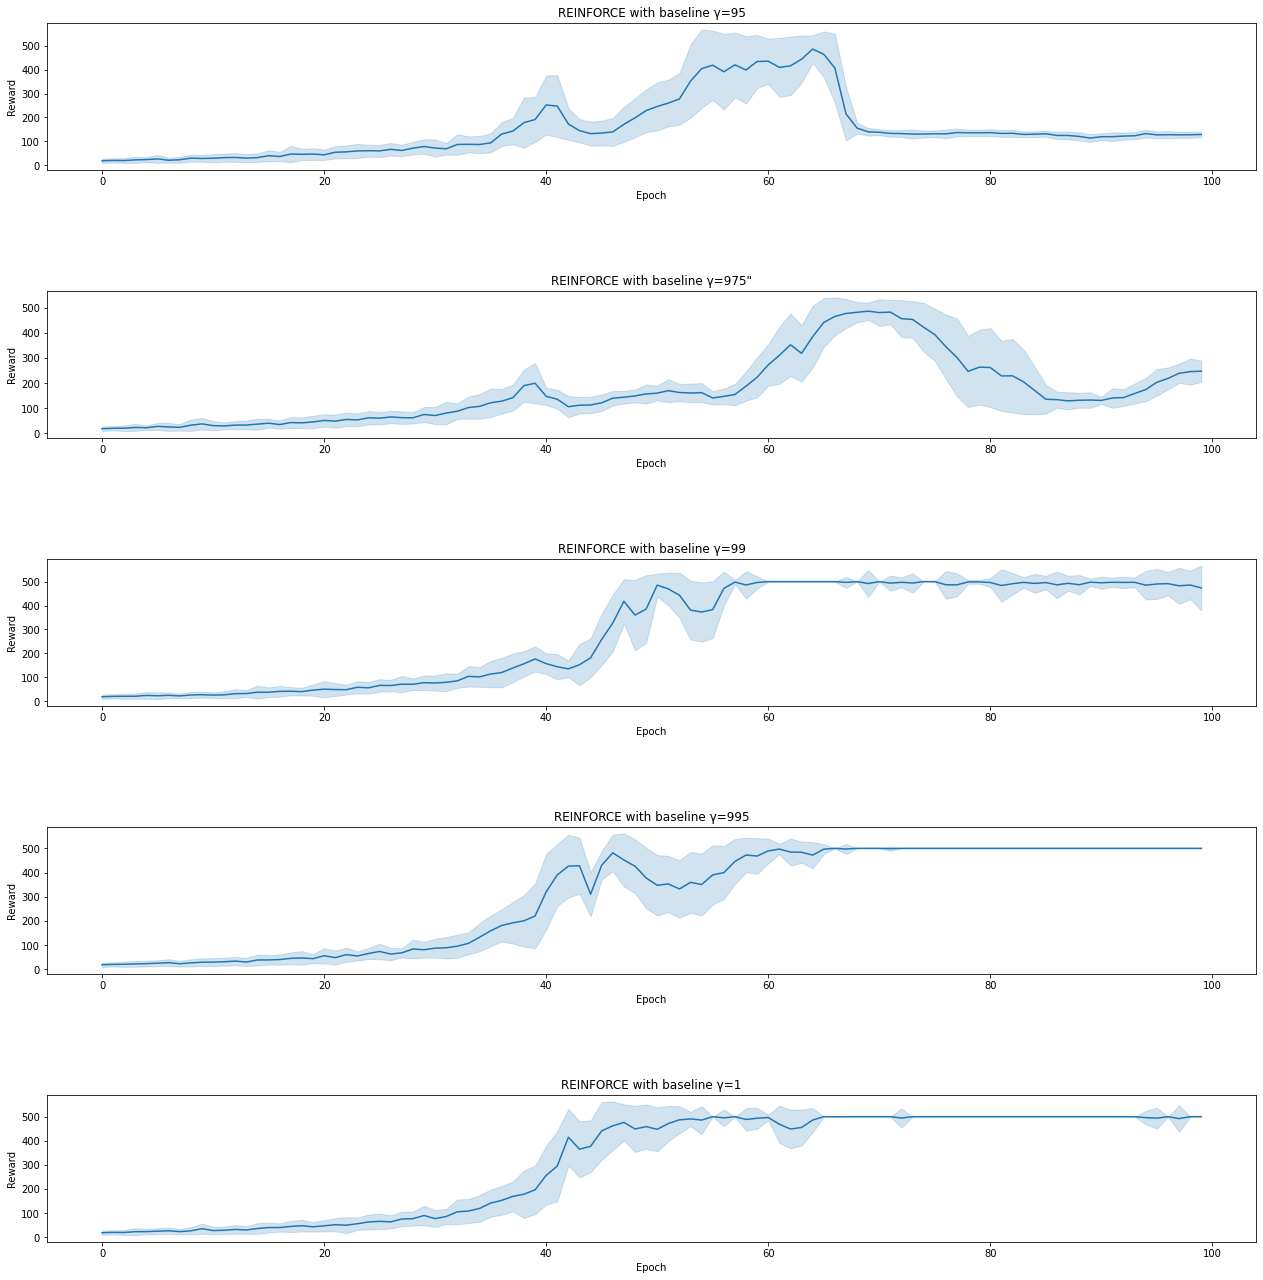

In [ ]:
# Insert your code here and run this cell

fig, ax = plt.subplots(5)
fig.tight_layout(pad=10.0)
titles= ["REINFORCE with baseline γ=0.95", 'REINFORCE with baseline γ=0.975"',"REINFORCE with baseline γ=0.99","REINFORCE with baseline γ=0.995","REINFORCE with baseline γ=1"]
for i in range(len(training_rewards_array)):
    BaseAgent.plot_rewards(training_rewards_array[i], ax[i])
    ax[i].title.set_text(titles[i])



plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

Here we see that the learning with a γ=0.95 converge at 100, the γ=0.975 run converge at around 200 the last 3 runs converged at 500. However γ=1 is the fastest to converge to the optimal value. The higher the gamma is the sooner the convergence will be. In this environment futures values seems to be important for optimal learning. One reason of that might be because the cartpole is sliding and if the cartpole is going out of the frame it fails the experiment. This is why at around 50 epoch we see a drop in performance for all the result because the cart is good enough to keep the pole up but hasn't learn how to stay centered yet. The learning rate of high gammas value is faster because we consider futur action as important as the current steps.

#Qn 2. ACTOR CRITIC [35 Marks]


### Qn 2.1 Implement a one-step Actor-Critic agent below [15 Marks]. 

Implement an actor critic agent below with the following policy gradient computation.

&emsp;&emsp; $\nabla_\theta J(\theta) = \sum_j \sum_t (G_{t:t+1}^j - V(s_t^j)) \nabla_\theta ln\pi_\theta (a_t^j|s_t^j)$ \\
where $G_{t:t+1}^j= R_t + \gamma V(s_{t+1}^j)$ is the truncated one-step return computed starting from the current state, $s_t^j$ for the episode $j$. \\


Implement the critic network to be an estimator for state-value function.

Note that you will be graded primarily on the output of the agent.train() and agent.evaluate() functions for this question.

In [ ]:
class ActorCriticAgent(BaseAgent):
    """ A2C Agent: Actor-Critic
        Here we try to FURTHER reduce the variance via bootstrapping.
    """

    def optimize_model(self, n_episodes: int):
        pass
        """ YOU NEED TO IMPLEMENT THIS METHOD

            This method is called at each training iteration and is responsible for
            (i) gathering a dataset of episodes
            (ii) computing the expectation of the policy gradient.
                 Note that you will only be computing the loss value
            In addition implement the critic network
            HINT:
                * If you've made it this far you don't need another hint!
        """
        #Actor-Critics parameters batch:
        #Actor-Critics parameters batch:
        log_probs_batch = []
        values_before_batch = []
        G_array_batch = []

        #For final output
        total_rewards = []

        for iter in range(n_episodes):
            observation = self.env.reset()
            #Reset
            done = False
            return_episode = 0
            observation = torch.tensor(observation, dtype=torch.float)[None, :]

            #Episode param
            G_array = []
            log_probs = []
            values_before = []

            while not done:
                probs = self.policy_model.forward(observation)
                value_before = self.value_model.forward(observation)

                m = Categorical(probs)
                action = m.sample()


                next_observation, reward, done, info = self.env.step(int(action))

                next_observation = torch.tensor(next_observation, dtype=torch.float)[None, :]
                value_after = self.value_model.forward(next_observation)
                if not done:
                    G = reward + self.gamma * value_after.item()
                else:
                    G = reward
                observation= next_observation
                log_probs.append(-m.log_prob(action))
                values_before.append(value_before.type(torch.float64))
                G_array.append(G)
                return_episode += reward

            log_probs_batch.append(log_probs)
            values_before_batch.append(values_before)
            G_array_batch.append(G_array)

            #Reward output
            total_rewards.append(return_episode)

        policy_loss = 0
        value_loss = 0


        criterion = nn.MSELoss()

        for log_probs,values_before,G_values in zip(log_probs_batch,values_before_batch,G_array_batch):

            critic = sum([(g - v) for v, g in zip(values_before, G_values)])

            policy_loss += sum([p*float(critic) for p,g in zip(log_probs,G_values)])

            value_loss += critic.pow(2)





        # ======================================================================
        # Policy optimizer
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        # Baseline backpropagation
        # additionally we update the value network parameters
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()
        return np.array(total_rewards)



Iteration 1/100: rewards 22.0 +/- 14.19
Iteration 2/100: rewards 18.75 +/- 7.27
Iteration 3/100: rewards 24.31 +/- 16.07
Iteration 4/100: rewards 23.81 +/- 10.7
Iteration 5/100: rewards 23.47 +/- 11.53
Iteration 6/100: rewards 22.5 +/- 10.86
Iteration 7/100: rewards 31.78 +/- 21.54
Iteration 8/100: rewards 25.22 +/- 14.59
Iteration 9/100: rewards 28.62 +/- 14.24
Iteration 10/100: rewards 22.81 +/- 11.99
Iteration 11/100: rewards 25.5 +/- 14.22
Iteration 12/100: rewards 26.19 +/- 12.28
Iteration 13/100: rewards 30.41 +/- 19.92
Iteration 14/100: rewards 25.94 +/- 9.7
Iteration 15/100: rewards 27.84 +/- 14.61
Iteration 16/100: rewards 40.44 +/- 19.71
Iteration 17/100: rewards 29.84 +/- 21.99
Iteration 18/100: rewards 36.69 +/- 21.4
Iteration 19/100: rewards 37.62 +/- 26.18
Iteration 20/100: rewards 36.09 +/- 21.43
Iteration 21/100: rewards 35.78 +/- 20.7
Iteration 22/100: rewards 41.12 +/- 23.1
Iteration 23/100: rewards 46.56 +/- 19.51
Iteration 24/100: rewards 43.25 +/- 24.03
Iteration 2

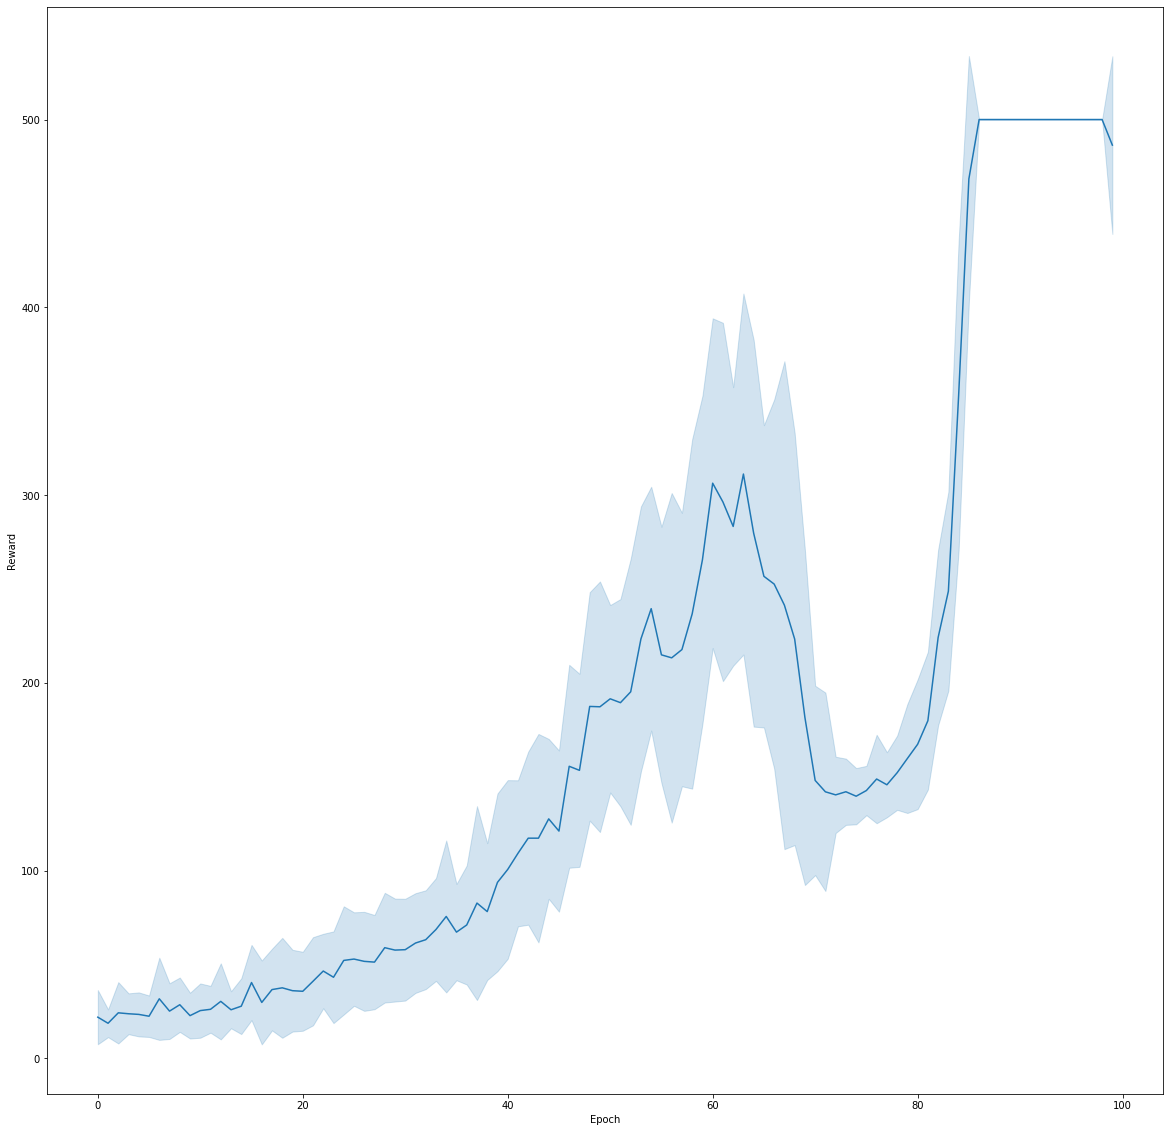

In [ ]:
# You will be graded on this output of this cell; so kindly run it
# Keep this config
# updated config on Nov 15
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 1,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-2,
    'use_baseline': True,
    'value_layers': [16, 8],
    'value_learning_rate': 1e-2,
}
agent = ActorCriticAgent(config)
ActorCritic_sum_rewards = agent.train(n_episodes=32, n_iterations=100)

In [ ]:
# You will be graded on this output of this cell; so kindly run it 
agent.evaluate()

Reward: 500.0


### Qn 2.2: Eventhough the previous `REINFORCEv2+B` agent used a value estimator network similar to that of the Actor-Critic agent why is not called an Actor-Critic method ? [ 3 Marks]

ActorCritic's method are known to bootstrap futur result in the current step estimation. The reinforce algorithm with baseline only consider the current step value.

### Qn 2.3: How does the Actor-Critic algorithm reduces variance? What about bias? We are using one-step rewards here, is there a way we can strike a balance between variance and bias? [5 Marks]

Actor-Critic method reduce the variance by using t+1 step state value. This can be generalize with t+1 value or generalize with eligibility traces. The $\hat{V}_{θ}(S_{i,t+1}) $ sets a baseline estimation. Baseline in reinforcement algorithm are known to reduce variance by reducing the range of action in the algorithm [1]. However, the actor critics methods are known to be biais because we use the value neural network to estimate the $\hat{V}_{θ}(S_{i,t+1}). Our algorithm is bias because of our estimation. To balance the variance and biais it is possible to to use Actor-Crtiics with eligibility traces. Eligibility traces is a way of weithing between temporal-difference "target" and Monte Carlo return [4]. Therefore adding more step could increase the variance and reduce the biais though our estimation since there is now have a combination of estimations. Hyperparameter tuning is another way to reduce the biais of the model. Indeed, if the value function is more accurate towards the real value the biais will be lower.

### Qn 2.4: Challenge! Can you tweak the hyperparameters of Actor-Critic to achieve better performance? Compare your results againts what you already have in section 3.1, in a single plot. [ 5 Marks]

Tune $\gamma$ within the same range as in Qn. 1.3.c and tune the hypereparameters of the value networks.

The first hyperparameter tunning iteration ran 49 policy/value layer networks combination have be tried. The experiments where done with a discount factor of 0.95. It would have taken 56 finish to complete the hyperparameter tuning of all discount factor. It has been decided to take the best neural network layer confiuration in the γ=0.95  run and find if there is a better discount factor then 0.95. This will reduce the number of iteration needed greatly.

After running the actor critics algorithm for differents discount factor values I have realise that the impact of γ is negligeable since we are looking only t+1 step. This would be different for eligibility traces. The γ hyperparameter tunning has been stopped when I realise that the runs results where almost the same. Previous result on question 1.3c showed that the gamma in the range of 0.99-1 had better performance. This is why it has been decided to use 0.995 as the final actorcriticsV2 gamma.

In [ ]:
# Insert your code here to search for best hyper-parameters

Streaming output truncated to the last 5000 lines.
Iteration 24/100: rewards 24.4 +/- 12.12
Iteration 25/100: rewards 22.98 +/- 10.84
Iteration 26/100: rewards 22.24 +/- 11.98
Iteration 27/100: rewards 21.18 +/- 8.76
Iteration 28/100: rewards 25.52 +/- 14.57
Iteration 29/100: rewards 24.48 +/- 13.76
Iteration 30/100: rewards 27.66 +/- 12.01
Iteration 31/100: rewards 29.92 +/- 21.4
Iteration 32/100: rewards 28.58 +/- 15.81
Iteration 33/100: rewards 29.16 +/- 18.02
Iteration 34/100: rewards 29.58 +/- 14.27
Iteration 35/100: rewards 29.02 +/- 20.39
Iteration 36/100: rewards 31.84 +/- 19.21
Iteration 37/100: rewards 29.6 +/- 13.85
Iteration 38/100: rewards 29.46 +/- 16.72
Iteration 39/100: rewards 35.44 +/- 20.71
Iteration 40/100: rewards 40.26 +/- 25.61
Iteration 41/100: rewards 32.1 +/- 14.25
Iteration 42/100: rewards 38.3 +/- 19.51
Iteration 43/100: rewards 32.88 +/- 15.51
Iteration 44/100: rewards 34.94 +/- 16.02
Iteration 45/100: rewards 37.9 +/- 22.91
Iteration 46/100: rewards 39.68 

KeyboardInterrupt: ignored

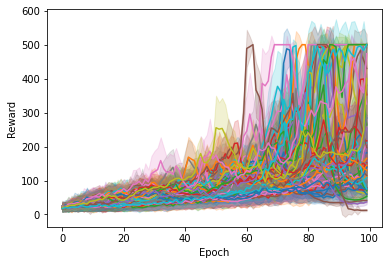

In [ ]:
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 1.0,
    'policy_layers': [16, 8],
    'policy_learning_rate': 1e-2,
    'use_baseline': True,
    'value_layers': [16,8],
    'value_learning_rate': 5e-2,
}
gammas = [0.95,0.975,0.99,0.9925,0.9975,0.995,1]
policy_learning_rate = [1e-1,1e-2,1e-3,5e-3]
value_learning_rate= [1e-1,1e-2,1e-3,5e-3]

value_policy_layers = [[8,4],[16, 8],[20, 10],[32, 16],[40, 20],[64,20],[80,20]]

training_rewards_actor_critics_array = []
param_history =[]
for gamma in gammas:
    print("Training for gamma:",gamma)
    config["gamma"] = gamma
    for policy_layer in value_policy_layers:
        for value_layer in value_policy_layers:
            config["value_layers"] = value_layer
            config["policy_layers"] =policy_layer
            print("Hyperparameter tuning with γ",gamma,"value_layers",value_layer,"policy_layer",policy_layer)
            agent = ActorCriticAgent(config)
            param_history.append([gamma,policy_layer,value_layer])
            training_rewards = agent.train(n_episodes=50, n_iterations=100)
            training_rewards_actor_critics_array.append(copy.deepcopy(training_rewards))

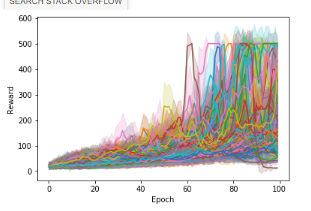

Training for gamma: 0.95
Hyperparameter tuning with γ 0.95 value_layers [16, 8] policy_layer [64, 20]
Iteration 1/100: rewards 20.06 +/- 11.93
Iteration 2/100: rewards 21.62 +/- 10.93
Iteration 3/100: rewards 28.16 +/- 13.39
Iteration 4/100: rewards 32.32 +/- 20.49
Iteration 5/100: rewards 34.58 +/- 21.31
Iteration 6/100: rewards 37.92 +/- 20.7
Iteration 7/100: rewards 36.9 +/- 23.32
Iteration 8/100: rewards 44.42 +/- 21.11
Iteration 9/100: rewards 51.36 +/- 20.3
Iteration 10/100: rewards 45.3 +/- 19.7
Iteration 11/100: rewards 55.3 +/- 24.84
Iteration 12/100: rewards 57.5 +/- 23.97
Iteration 13/100: rewards 63.44 +/- 24.48
Iteration 14/100: rewards 57.4 +/- 14.59
Iteration 15/100: rewards 62.62 +/- 18.04
Iteration 16/100: rewards 73.68 +/- 31.21
Iteration 17/100: rewards 69.84 +/- 21.79
Iteration 18/100: rewards 62.12 +/- 13.96
Iteration 19/100: rewards 71.62 +/- 23.45
Iteration 20/100: rewards 72.8 +/- 18.32
Iteration 21/100: rewards 72.24 +/- 27.11
Iteration 22/100: rewards 73.04 +/

KeyboardInterrupt: ignored

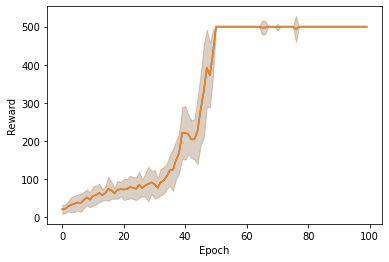

In [ ]:
config_gamma = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 1.0,
    'policy_layers': [64, 20],
    'policy_learning_rate': 1e-2,
    'use_baseline': True,
    'value_layers': [16, 8],
    'value_learning_rate': 5e-2,
}
gammas = [0.95,0.975,0.99,0.9925,0.9975,0.995,1]
training_rewards_actor_critics_array = []
for gamma in gammas:
    print("Training for gamma:",gamma)
    config["gamma"] = gamma
    print("Hyperparameter tuning with γ",gamma,"value_layers",config_gamma["value_layers"],"policy_layer",config_gamma["policy_layers"])
    agent = ActorCriticAgent(config_gamma)
    param_history.append([gamma,policy_layer,value_layer])
    training_rewards = agent.train(n_episodes=50, n_iterations=100)
    training_rewards_actor_critics_array.append(copy.deepcopy(training_rewards))

Iteration 1/100: rewards 21.09 +/- 13.18
Iteration 2/100: rewards 23.91 +/- 13.7
Iteration 3/100: rewards 27.66 +/- 15.89
Iteration 4/100: rewards 20.16 +/- 6.88
Iteration 5/100: rewards 37.25 +/- 18.33
Iteration 6/100: rewards 35.81 +/- 15.66
Iteration 7/100: rewards 32.72 +/- 12.94
Iteration 8/100: rewards 40.12 +/- 20.81
Iteration 9/100: rewards 37.41 +/- 15.24
Iteration 10/100: rewards 44.56 +/- 20.26
Iteration 11/100: rewards 47.44 +/- 21.63
Iteration 12/100: rewards 57.47 +/- 29.72
Iteration 13/100: rewards 56.81 +/- 22.12
Iteration 14/100: rewards 50.53 +/- 19.1
Iteration 15/100: rewards 54.59 +/- 17.86
Iteration 16/100: rewards 55.41 +/- 25.23
Iteration 17/100: rewards 57.25 +/- 21.82
Iteration 18/100: rewards 60.72 +/- 19.97
Iteration 19/100: rewards 65.88 +/- 32.24
Iteration 20/100: rewards 71.84 +/- 22.42
Iteration 21/100: rewards 70.78 +/- 22.98
Iteration 22/100: rewards 68.16 +/- 33.54
Iteration 23/100: rewards 78.88 +/- 46.62
Iteration 24/100: rewards 80.81 +/- 39.59
Iter

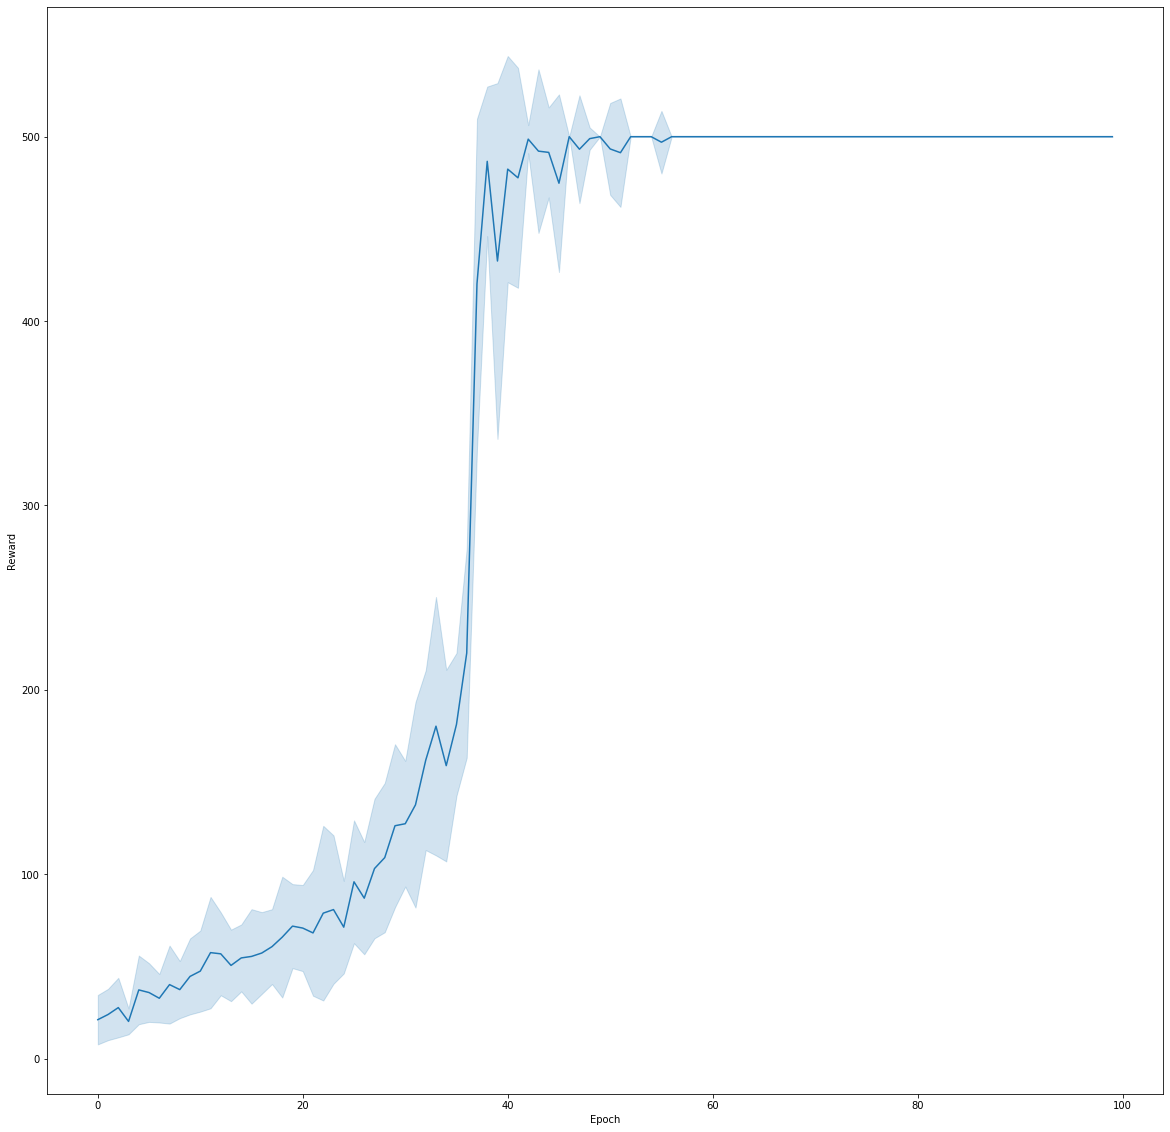

In [ ]:
# Provide your best config here and run this cell
config = {
    'env_id': 'CartPole-v1',
    'seed': 8953,
    'gamma': 0.995,
    'policy_layers': [64, 20],
    'policy_learning_rate': 1e-2,
    'use_baseline': True,
    'value_layers': [16, 8],
    'value_learning_rate': 5e-2,
}
agent = ActorCriticAgent(config)
ActorCritic_rewards2 = agent.train(n_episodes=32, n_iterations=100)

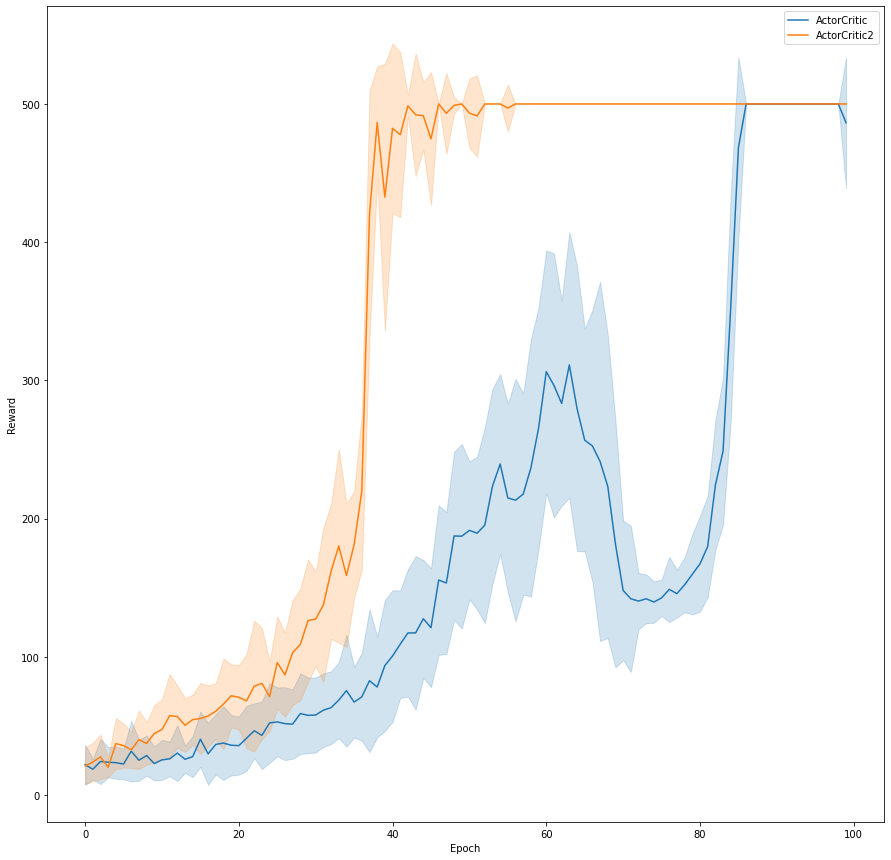

In [ ]:
# You will be graded on the output of this cell; So kindly run it
fig, ax = plt.subplots()
BaseAgent.plot_rewards(ActorCritic_sum_rewards, ax)
BaseAgent.plot_rewards(ActorCritic_rewards2, ax)
plt.rcParams['figure.figsize'] = [12, 12]
plt.legend(labels=['ActorCritic', 'ActorCritic2'])
plt.show()

We ahve imporved the performance of the actorcritic by modifying the number of layer in the policy layer network.

### Qn 2.5: Compare and plot `REINFORCEv2+B' method and 'ACTOR-CRITIC' method. [5 Marks]
Report your observations and provide explanations for the same. 

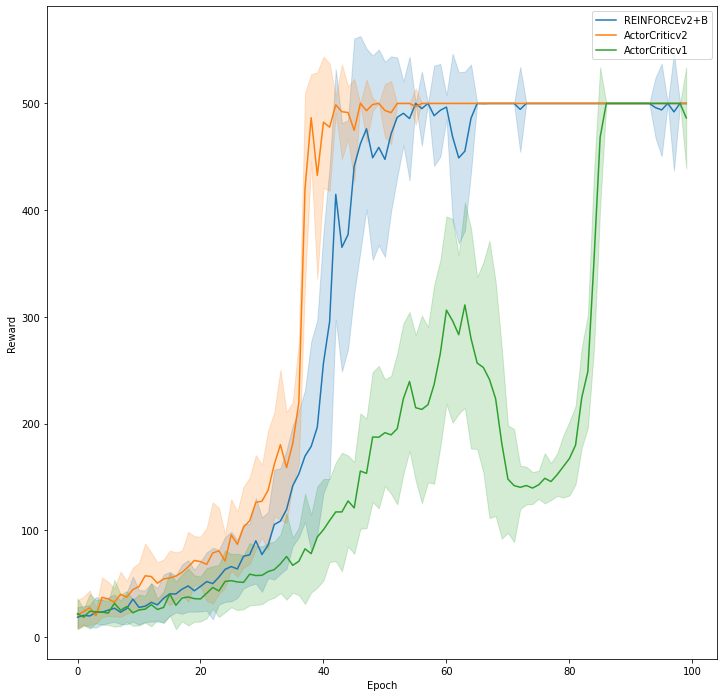

In [ ]:
# You will be graded on the output of this cell; So kindly run it
fig, ax = plt.subplots()
BaseAgent.plot_rewards(REINFORCEv2PlusBaselineAgent_rewards, ax)
BaseAgent.plot_rewards(ActorCritic_rewards2, ax)
BaseAgent.plot_rewards(ActorCritic_sum_rewards, ax)
plt.rcParams['figure.figsize'] = [12, 12]
plt.legend(labels=['REINFORCEv2+B', 'ActorCriticv2',"ActorCriticv1"])
plt.show()

I decided to include the actorCriticV1 because it has use the same policy network as the reinforce algorithm with baseline.

ActorCriticv1 is the version with the default configuration. The ActorCriticV2 is the version with the hyperparameter tuning.

It is possible to see that the ActorCriticv2 is the fastest algorithm to converge at 40 epoch. After the reinforce algorithm showed better convergence performance at about 55 epochs. Finally, the Actorcriticv1 takes the longer to converge at approximately 83 epochs.

 Here we can see that all methods converge to to 500 with a very low variance. The actorCriticV1 variance seems to be higher then the ActorCriticV2 variance and reinforce with baseline. The ActorCritic algorithm have a significatly lower variance when ascending compare to the reinforce algorithm. This corobarate the litterature about actor critic that says there lower variance but higher biais.

Moreover, it is intresting to point out that once the actor critic algorithm converge to the optimal value it tends to have a lower variance then the reinforce algorithm.  We can see that the reinforce algorithm have higher variance spike at around 75 epoch and 90-100 epoch. When actorcriticsV2 reaches the maximum value it stays very stable for the 60 following iterations.

Lower variance can help in learning an optimal policy faster because it reduce the set of action. The optimal actions have better chance of being selected.


































### Qn 2.6: Plot all methods [2 Marks]

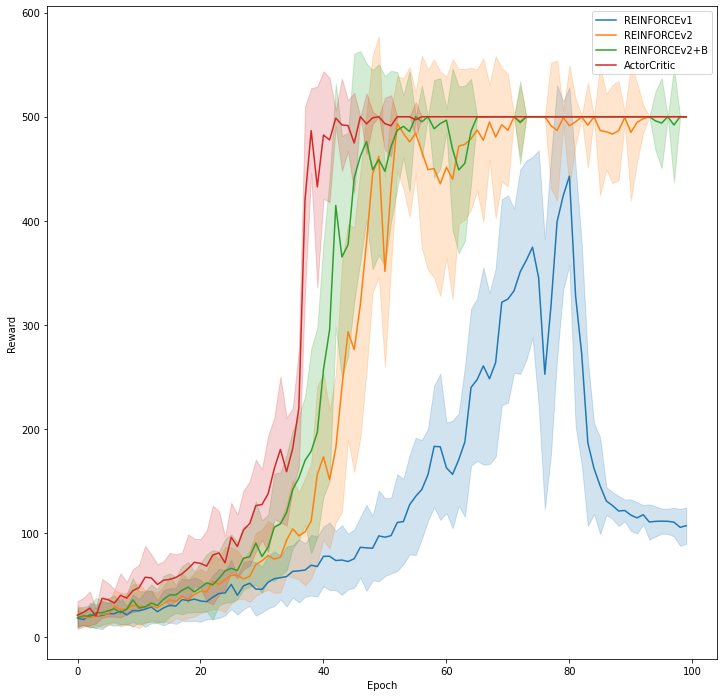

In [ ]:
# You will be graded on the output of this cell; So kindly run it
fig, ax = plt.subplots()
BaseAgent.plot_rewards(REINFORCEv1_rewards, ax)
BaseAgent.plot_rewards(REINFORCEv2_rewards, ax)
BaseAgent.plot_rewards(REINFORCEv2PlusBaselineAgent_rewards, ax)
BaseAgent.plot_rewards(ActorCritic_rewards2, ax)
plt.rcParams['figure.figsize'] = [12, 12]
plt.legend(labels=['REINFORCEv1', 'REINFORCEv2', 'REINFORCEv2+B', 'ActorCritic'])
plt.show()

In summary, adding a baseline allows us to reduce the variance and speed up the learning. The results showed faster convergence for actor critics methods with a convergence with very low variance at 50 epoch.

##References :

[1] Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press. <br>
[2] Chung, Wesley, Valentin Thomas, Marlos C. Machado, and Nicolas Le Roux. "Beyond variance reduction: Understanding the true impact of baselines on policy optimization." In International Conference on Machine Learning, pp. 1999-2009. PMLR, 2021. <br>
[3]Chen, G. (2019). Merging Deterministic Policy Gradient Estimations with Varied Bias-Variance Tradeoff for Effective Deep Reinforcement Learning. arXiv preprint arXiv:1911.10527. <br>
[4] Salloum Zia (2019) Eligibility Traces in Reinforcement Learning,[Online]: https://towardsdatascience.com/eligibility-traces-in-reinforcement-learning-a6b458c019d6#:~:text=Eligibility%20traces%20is%20a%20way,have%20a%20better%20learning%20performance.


In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Colab Notebooks/RL3_INF8953DE-A3.ipynb ./

cp: cannot stat '/content/drive/MyDrive/Colab': No such file or directory
cp: cannot stat 'Notebooks/RL3_INF8953DE-A3.ipynb': No such file or directory


In [ ]:
!jupyter nbconvert --to PDF " /content/drive/MyDrive/Colab Notebooks/RL3_INF8953DE-A3.ipynb"

[NbConvertApp] WARNING | pattern u' /content/drive/MyDrive/Colab Notebooks/RL3_INF8953DE-A3.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--no-input
    Exclude input cells and output prompts from converted document. 
    This mode is ideal for generating code-free reports.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulting notebook with defa